# Description

This notebook runs some pre-analyses using DBSCAN to explore the best set of parameters (`min_samples` and `eps`) to cluster `z_score_std` data version. I'm following [this](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) heuristic to pick these parameters.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

2

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=2
env: OPEN_BLAS_NUM_THREADS=2
env: NUMEXPR_NUM_THREADS=2
env: OMP_NUM_THREADS=2


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name
from clustering.ensembles.utils import generate_ensemble

# Global settings

In [5]:
np.random.seed(0)

In [6]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: z_score_std

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3752, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## Tests different k values (k-NN)

In [13]:
# `k_values` is the full range of k for kNN, whereas `k_values_to_explore` is a
# subset that will be explored in this notebook. If the analysis works, then
# `k_values` and `eps_range_per_k` below are copied to the notebook that will
# produce the final DBSCAN runs (`../002_[...]-dbscan-....ipynb`)
k_values = np.arange(2, 125 + 1, 1)
k_values_to_explore = (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125)

In [14]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [15]:
eps_range_per_k = {
    k: (34, 50)
    if k < 5
    else (35, 50)
    if k < 15
    else (37, 58)
    if k < 75
    else (38, 58)
    if k < 100
    else (39, 60)
    for k in k_values
}

eps_range_per_k_to_explore = {k: eps_range_per_k[k] for k in k_values_to_explore}

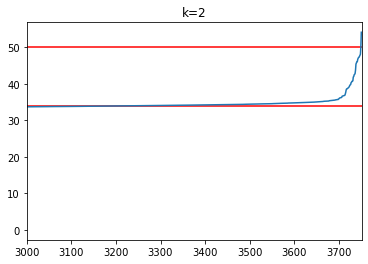

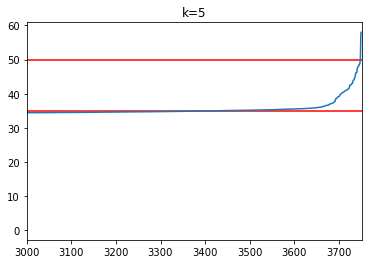

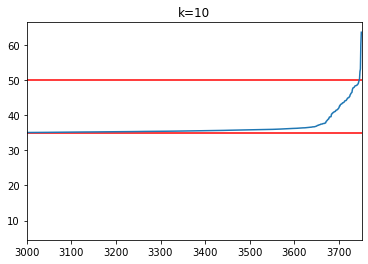

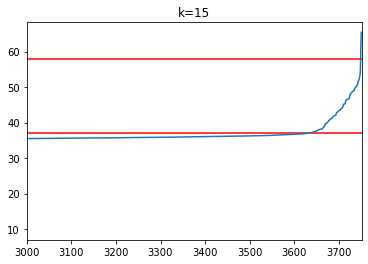

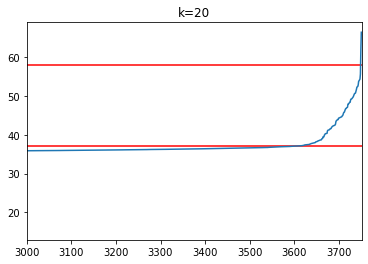

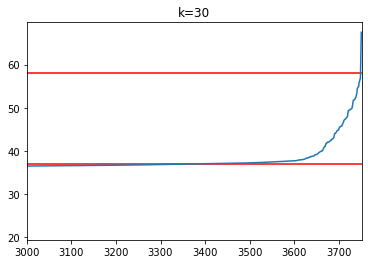

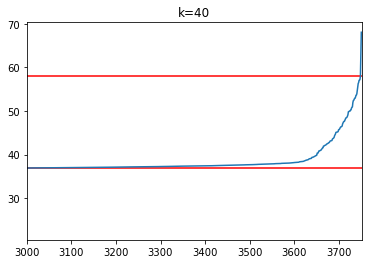

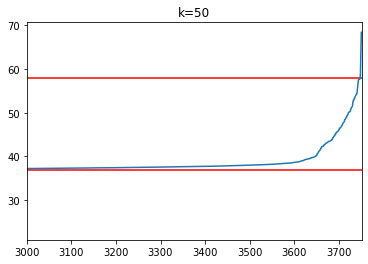

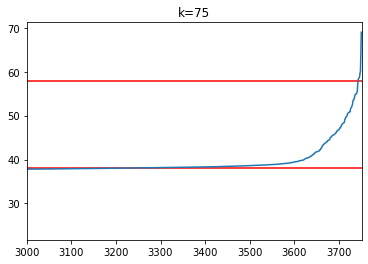

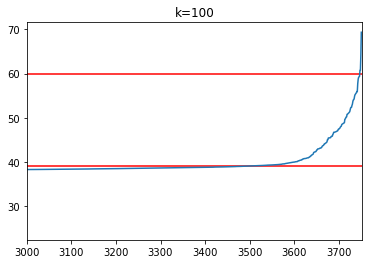

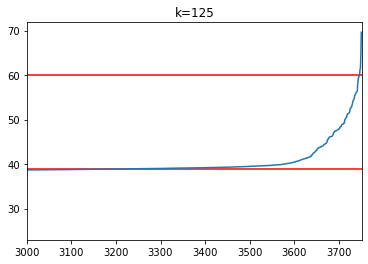

In [16]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

# Extended test

## Generate clusterers

In [17]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values_to_explore
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k_to_explore
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125),
 'EPS_RANGE_PER_K': {2: (34, 50),
  5: (35, 50),
  10: (35, 50),
  15: (37, 58),
  20: (37, 58),
  30: (37, 58),
  40: (37, 58),
  50: (37, 58),
  75: (38, 58),
  100: (39, 60),
  125: (39, 60)},
 'EPS_STEP': 33,
 'METRIC': 'euclidean'}

In [18]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [19]:
display(len(CLUSTERERS))

363

In [20]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=34.0, metric='precomputed', min_samples=2, n_jobs=2))

('DBSCAN #1', DBSCAN(eps=34.5, metric='precomputed', min_samples=2, n_jobs=2))

In [21]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

## Generate ensemble

In [22]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [23]:
data_dist.shape

(3752, 3752)

In [24]:
pd.Series(data_dist.flatten()).describe().apply(str)

count           14077504.0
mean     44.28544330426931
std      3.577640598713617
min                    0.0
25%      43.06948280261282
50%      44.01529629505707
75%      44.99092415488099
max      86.59317722681895
dtype: object

In [25]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 363/363 [01:01<00:00,  5.95it/s]


In [26]:
ensemble.shape

(68, 3)

In [27]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 34.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",94
DBSCAN #1,"{'algorithm': 'auto', 'eps': 34.5, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44
DBSCAN #2,"{'algorithm': 'auto', 'eps': 35.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29
DBSCAN #3,"{'algorithm': 'auto', 'eps': 35.5, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22
DBSCAN #4,"{'algorithm': 'auto', 'eps': 36.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20


In [28]:
_tmp = ensemble["n_clusters"].value_counts()
display(_tmp)
assert _tmp.index[0] == 2
assert _tmp.loc[2] == 27

2     27
5      8
4      7
3      4
8      3
20     3
17     3
7      3
12     2
10     1
9      1
44     1
13     1
19     1
22     1
29     1
94     1
Name: n_clusters, dtype: int64

In [29]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    68.000000
mean      8.147059
std      13.069578
min       2.000000
25%       2.000000
50%       4.000000
75%       8.000000
max      94.000000
Name: n_clusters, dtype: float64

In [30]:
# number of noisy points
_tmp = ensemble.copy()
_tmp = _tmp.assign(n_noisy=ensemble["partition"].apply(lambda x: np.isnan(x).sum()))

In [31]:
_tmp_stats = _tmp["n_noisy"].describe()
display(_tmp_stats)
assert _tmp_stats["max"] < 520
assert 60 < _tmp_stats["mean"] < 70

count     68.000000
mean      65.132353
std       72.718616
min        5.000000
25%       23.500000
50%       42.500000
75%       79.000000
max      511.000000
Name: n_noisy, dtype: float64

## Testing

In [32]:
assert ensemble_stats["min"] > 1

In [33]:
assert not ensemble["n_clusters"].isna().any()

In [34]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

## Add clustering quality measures

In [35]:
def _remove_nans(data, part):
    not_nan_idx = ~np.isnan(part)
    return data.iloc[not_nan_idx], part[not_nan_idx]


def _apply_func(func, data, part):
    no_nan_data, no_nan_part = _remove_nans(data, part)
    return func(no_nan_data, no_nan_part)

In [36]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: _apply_func(silhouette_score, data, x)
    ),
    ch_score=ensemble["partition"].apply(
        lambda x: _apply_func(calinski_harabasz_score, data, x)
    ),
    db_score=ensemble["partition"].apply(
        lambda x: _apply_func(davies_bouldin_score, data, x)
    ),
)

In [37]:
ensemble.shape

(68, 6)

In [38]:
ensemble.head()

,clusterer_params,partition,n_clusters,si_score,ch_score,db_score
clusterer_id,,,,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 34.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",94,0.023921,3.199500,1.212747
DBSCAN #1,"{'algorithm': 'auto', 'eps': 34.5, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44,0.014158,4.259830,1.168378
DBSCAN #2,"{'algorithm': 'auto', 'eps': 35.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,0.031332,5.477907,1.138848
DBSCAN #3,"{'algorithm': 'auto', 'eps': 35.5, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22,0.048892,6.390954,1.179776
DBSCAN #4,"{'algorithm': 'auto', 'eps': 36.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20,0.079158,6.816291,1.140895


# Cluster quality

In [39]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,si_score,ch_score,db_score
n_clusters,,,
2,0.190294,13.922015,1.278473
3,0.223594,8.243559,1.301857
4,0.162990,12.776405,1.275792
5,0.096820,12.728950,1.255015
7,0.213418,8.325802,1.197106
8,0.185028,7.679106,1.173459
9,0.185690,7.839758,1.242830
10,0.149295,8.880184,1.249491
12,0.137707,8.986085,1.259991


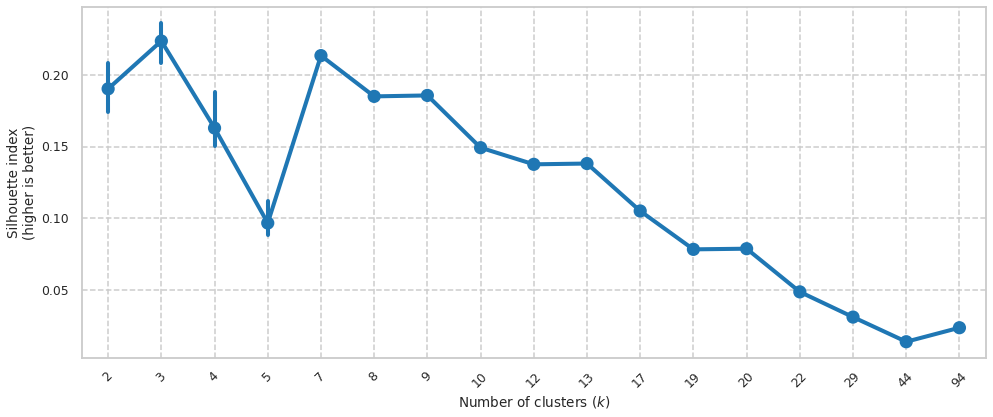

In [40]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

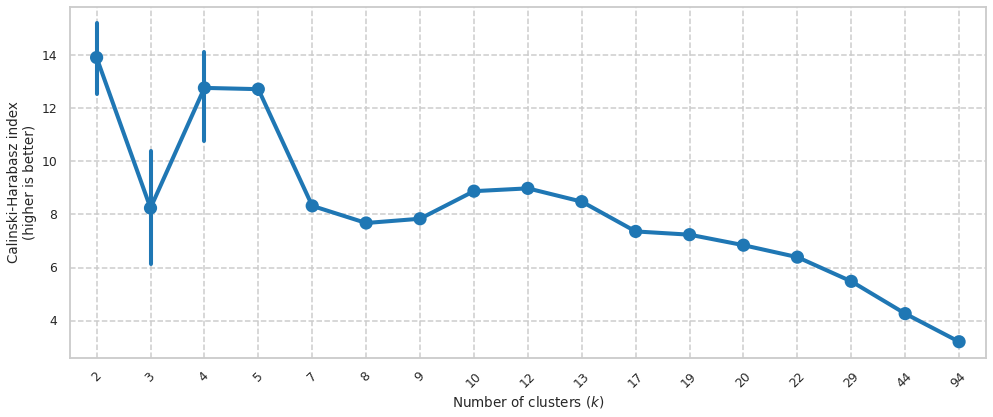

In [41]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

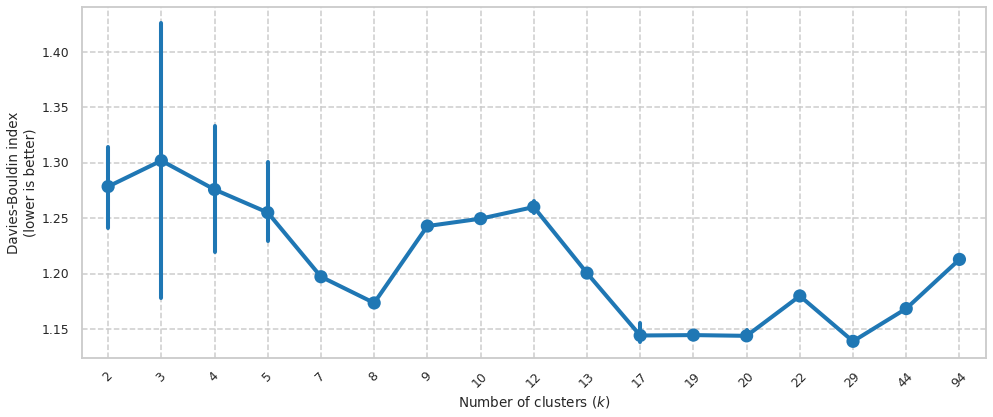

In [42]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="db_score")
    ax.set_ylabel("Davies-Bouldin index\n(lower is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Conclusions

The values explored above for `k_values` and `eps_range_per_k` are the one that will be used for DBSCAN in this data version.